In [1]:
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,random_split
import optuna
import matplotlib.pyplot as plt

## Importing the tensors

In [2]:
import torch

# Load training data
inp_train = torch.tensor(torch.load('/content/target_train.txt'))
target_train = torch.tensor(torch.load('/content/target_train.txt'))

# Load validation data
inp_val = torch.tensor(torch.load('/content/inp_val.txt'))
target_val = torch.tensor(torch.load('/content/target_val.txt'))

# Load test data
inp_test = torch.tensor(torch.load('/content/inp_test.txt'))
target_test = torch.tensor(torch.load('/content/target_test.txt'))


<ipython-input-2-721d7d9b1dcb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp_train = torch.tensor(torch.load('/content/target_train.txt'))
<ipython-input-2-721d7d9b1dcb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_train = torch.tensor(torch.load('/content/target_train.txt'))
<ipython-input-2-721d7d9b1dcb>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp_val = torch.tensor(torch.load('/content/inp_val.txt'))
<ipython-input-2-721d7d9b1dcb>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourc

In [4]:
torch.__version__
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [7]:
# Create DataLoader for training set
train_dataloader = DataLoader(TensorDataset(inp_train.float(), target_train.float()), batch_size=30, shuffle=True, drop_last=True)

# Create DataLoader for validation set
val_dataloader = DataLoader(TensorDataset(inp_val.float(), target_val.float()), batch_size=30, shuffle=True, drop_last=True)

## Creating the transformer for the reward function

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)

        # Info
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)

        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)

        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [9]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # for get_params
        self.num_tokens = num_tokens
        self.num_heads = num_heads
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dropout_p = dropout_p

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=200
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
            batch_first=True
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None, batch_first=True):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        #src = self.embedding(src) * math.sqrt(self.dim_model)
            #tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        #print(src.shape, tgt.shape)
        #transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        transformer_out = self.transformer(src, tgt, src_key_padding_mask=src_pad_mask)

        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]

        return mask
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        mask = []
        pad_token = 500
        #print(matrix)
        for i in range(0, matrix.size(0)):
            seq = []
            for j in range(0, matrix.size(1)):
                if matrix[i,j,0] == pad_token:
                    seq.append(True)
                else:
                    seq.append(False)
            mask.append(seq)
        result = torch.tensor(mask)
        #print(matrix, result, result.shape)
        return result

In [10]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, inputs, targets):
        #typeLoss = nn.CrossEntropyLoss()
        ParameterLoss = nn.MSELoss()

        #loss = 0.5 * typeLoss(inputs[:,:,:6], targets[:,:,:6]) + 0.5 * ParameterLoss(inputs[:,:,6:12], targets[:,:,6:12])
        #print(inputs[:,:,:6], inputs[:,:,:6].shape, targets[:,:,6:12], targets[:,:,6:12].shape)

        loss = ParameterLoss(inputs[:,:,:1], targets[:,:,:1])

        return loss

In [11]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """

    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[0], batch[1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        opt.zero_grad()

        #tgt_mask = model.get_tgt_mask(sequence_length).to(device)
        pad_mask_src = model.create_pad_mask(X, 500).to(device)
        #pad_mask_tgt = model.create_pad_mask(y, 10).to(device)

        # Standard training except we pass in y_input and tgt_mask
        #print(X.shape, y.shape)
        pred = model(X, y, src_pad_mask=pad_mask_src)

        #print('Predictions: ',pred[:,:,:1])

        # Permute pred to have batch size first again
        #pred = pred.permute(1, 2, 0)
        loss = loss_fn(pred, y)

        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [12]:
def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """

    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[0], batch[1]
            X, y = torch.tensor(X, device=device), torch.tensor(y, device=device)

            #tgt_mask = model.get_tgt_mask(sequence_length).to(device)
            pad_mask_src = model.create_pad_mask(X, 500).to(device)
            #pad_mask_tgt = model.create_pad_mask(y, 10).to(device)

            # Standard training except we pass in y_input and src_mask
            #print("val ", X.shape, y.shape, X.dtype, y.dtype)
            #pred = model(X, y, tgt_mask, src_pad_mask=pad_mask_src, tgt_pad_mask=pad_mask_tgt)
            pred = model(X, y, src_pad_mask=pad_mask_src)


            # Permute pred to have batch size first again
            #pred = pred.permute(1, 2, 0)
            loss = loss_fn(pred, y)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)

## Hyperparameter tuning

In [13]:
from transformer_for_reward_function import Transformer, CustomLoss

MAX_EPOCHS = 20
loss_function = CustomLoss()

def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_encoder_layers = trial.suggest_categorical('num_encoder_layers', [2, 4, 6, 8])
    num_decoder_layers = trial.suggest_categorical('num_decoder_layers', [4, 6, 8,10])
    # batch_size = trial.suggest_categorical('batch_size', [64])
    num_heads = trial.suggest_categorical('num_heads', [2,3,6,47])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)
    #use_positional_encoder = trial.suggest_categorical('pos_encoder_max_len', [True, False])

    print(f'Parameters selected')
    #print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; use_positional_encoder; dropout')
    print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout')
    #print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate}; {num_heads}; {use_positional_encoder}; {dropout}'.replace('.', ','))
    print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate}; {num_heads}; {dropout}'.replace('.', ','))

    # Instantiate the model with suggested hyperparameters
    model = Transformer(
        dim_model=282,
        num_heads=num_heads,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dropout_p=dropout,
        num_tokens= inp_train.size()[1],
        #use_positional_encoder=use_positional_encoder
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_list, validation_loss_list = [], []

    validation_loss = -1
    # Training loop with early stopping, validation, etc.
    for epoch in range(MAX_EPOCHS):
        print(f' =========== EPOCH {epoch} ===========')

        train_loss = train_loop(model, optimizer, loss_function, train_dataloader)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_function, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f'Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

        # Report the validation loss to Optuna
        trial.report(validation_loss, epoch)

        # Implement early stopping logic
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    print(f'Best validation loss: {validation_loss}')
    #print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; use_positional_encoder; dropout;')
    print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;')
    #print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate:.8f}; {num_heads}; {use_positional_encoder}; {dropout:.8f}; Validation; '.replace('.', ','),
          #"; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in validation_loss_list]))

    print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate:.8f}; {num_heads}; {dropout:.8f}; Validation; '.replace('.', ','),
          "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in validation_loss_list]))
    print(f' ; ; ; ; ; Train; ',
          "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in train_loss_list]))

    return validation_loss

In [29]:
my_study = optuna.create_study(
    direction='minimize',
    study_name='for_reward_5', # IMPORTANT: Chance Name when new Dataset
    storage='sqlite:///animate_svg_optuna.db',
    load_if_exists=True
)

[I 2024-03-16 19:38:32,356] A new study created in RDB with name: for_reward_5


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_study.optimize(objective, n_trials=80)

Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,0003412000262445707; 2; 0,252150842191467
 =========== EPOCH 0 ===========


<ipython-input-11-b24b9f5ee9ad>:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-12-72c90ba90ff0>:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train Loss: 1.3622, Validation Loss: 1.2570
 =========== EPOCH 1 ===========
Train Loss: 0.8670, Validation Loss: 0.7767
 =========== EPOCH 2 ===========
Train Loss: 0.7678, Validation Loss: 2.5720
 =========== EPOCH 3 ===========
Train Loss: 0.7354, Validation Loss: 2.3863
 =========== EPOCH 4 ===========
Train Loss: 0.8116, Validation Loss: 1.0347
 =========== EPOCH 5 ===========
Train Loss: 0.7914, Validation Loss: 1.5968
 =========== EPOCH 6 ===========
Train Loss: 0.7273, Validation Loss: 1.6256
 =========== EPOCH 7 ===========
Train Loss: 0.7826, Validation Loss: 1.7730
 =========== EPOCH 8 ===========
Train Loss: 0.7444, Validation Loss: 1.4892
 =========== EPOCH 9 ===========
Train Loss: 0.7120, Validation Loss: 1.4149
 =========== EPOCH 10 ===========
Train Loss: 0.7723, Validation Loss: 1.3960
 =========== EPOCH 11 ===========
Train Loss: 0.6941, Validation Loss: 1.4305
 =========== EPOCH 12 ===========
Train Loss: 0.7143, Validation Loss: 2.2280
 =========== EPOCH 13 =======

[I 2024-03-16 19:40:08,651] Trial 0 finished with value: 1.475909662246704 and parameters: {'learning_rate': 0.0003412000262445707, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'num_heads': 2, 'dropout': 0.252150842191467}. Best is trial 0 with value: 1.475909662246704.


Train Loss: 0.7232, Validation Loss: 1.4759
Best validation loss: 1.475909662246704
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
2; 6; 0,00034120; 2; 0,25215084; Validation;  1,2570; 0,7767; 2,5720; 2,3863; 1,0347; 1,5968; 1,6256; 1,7730; 1,4892; 1,4149; 1,3960; 1,4305; 2,2280; 1,8061; 1,5385; 1,4284; 1,4344; 1,4163; 1,5390; 1,4759
 ; ; ; ; ; Train;  1,3622; 0,8670; 0,7678; 0,7354; 0,8116; 0,7914; 0,7273; 0,7826; 0,7444; 0,7120; 0,7723; 0,6941; 0,7143; 0,6966; 0,6954; 0,7254; 0,7361; 0,7085; 0,7159; 0,7232
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 10; 0,00020693010160242341; 47; 0,151433804306645
 =========== EPOCH 0 ===========
Train Loss: 1.5134, Validation Loss: 1.8312
 =========== EPOCH 1 ===========
Train Loss: 0.6550, Validation Loss: 1.9108
 =========== EPOCH 2 ===========
Train Loss: 0.6201, Validation Loss: 2.4995
 =========== EPOCH 3 ===========
Train Loss: 0.5431, Validation Loss: 2.4908
 ==

[I 2024-03-16 19:42:28,453] Trial 1 finished with value: 2.395620171229045 and parameters: {'learning_rate': 0.00020693010160242341, 'num_encoder_layers': 6, 'num_decoder_layers': 10, 'num_heads': 47, 'dropout': 0.151433804306645}. Best is trial 0 with value: 1.475909662246704.


Train Loss: 0.5413, Validation Loss: 2.3956
Best validation loss: 2.395620171229045
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 10; 0,00020693; 47; 0,15143380; Validation;  1,8312; 1,9108; 2,4995; 2,4908; 1,7092; 2,4695; 2,5353; 1,8273; 2,1279; 2,3083; 2,1504; 1,6302; 2,1081; 2,2522; 1,9432; 2,0722; 2,4537; 1,8656; 2,2483; 2,3956
 ; ; ; ; ; Train;  1,5134; 0,6550; 0,6201; 0,5431; 0,5503; 0,5151; 0,5496; 0,4979; 0,5191; 0,5140; 0,4992; 0,5128; 0,5431; 0,4532; 0,5703; 0,5344; 0,4706; 0,4970; 0,4799; 0,5413
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0001079850674085742; 47; 0,14797772933311013
 =========== EPOCH 0 ===========
Train Loss: 1.1525, Validation Loss: 1.0311
 =========== EPOCH 1 ===========
Train Loss: 0.4705, Validation Loss: 0.4684
 =========== EPOCH 2 ===========
Train Loss: 0.3539, Validation Loss: 0.4153
 =========== EPOCH 3 ===========
Train Loss: 0.3360, Validation Loss: 0.4135
 

[I 2024-03-16 19:44:04,677] Trial 2 finished with value: 0.20615317126115162 and parameters: {'learning_rate': 0.0001079850674085742, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.14797772933311013}. Best is trial 2 with value: 0.20615317126115162.


Train Loss: 0.1285, Validation Loss: 0.2062
Best validation loss: 0.20615317126115162
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00010799; 47; 0,14797773; Validation;  1,0311; 0,4684; 0,4153; 0,4135; 0,3617; 0,7987; 0,4205; 0,3817; 0,1930; 0,2128; 0,2631; 0,2259; 0,3763; 0,2060; 0,3249; 0,1398; 0,1020; 0,1759; 0,1430; 0,2062
 ; ; ; ; ; Train;  1,1525; 0,4705; 0,3539; 0,3360; 0,2428; 0,3001; 0,2230; 0,2234; 0,1875; 0,2100; 0,1804; 0,1827; 0,1896; 0,1826; 0,1728; 0,1519; 0,1770; 0,1944; 0,1713; 0,1285
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
8; 8; 0,004462049532792837; 47; 0,22594188504945548
 =========== EPOCH 0 ===========
Train Loss: 2.1672, Validation Loss: 1.5655
 =========== EPOCH 1 ===========
Train Loss: 1.5040, Validation Loss: 1.5297
 =========== EPOCH 2 ===========
Train Loss: 1.5188, Validation Loss: 1.5741
 =========== EPOCH 3 ===========
Train Loss: 1.5286, Validation Loss: 1.4781
 

[I 2024-03-16 19:46:20,861] Trial 3 finished with value: 1.509256410598755 and parameters: {'learning_rate': 0.004462049532792837, 'num_encoder_layers': 8, 'num_decoder_layers': 8, 'num_heads': 47, 'dropout': 0.22594188504945548}. Best is trial 2 with value: 0.20615317126115162.


Train Loss: 1.4869, Validation Loss: 1.5093
Best validation loss: 1.509256410598755
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
8; 8; 0,00446205; 47; 0,22594189; Validation;  1,5655; 1,5297; 1,5741; 1,4781; 1,5488; 1,5505; 1,9791; 1,4797; 1,5793; 1,6810; 1,6436; 1,6661; 1,7239; 1,4646; 1,5032; 1,5561; 1,5356; 1,6001; 1,4754; 1,5093
 ; ; ; ; ; Train;  2,1672; 1,5040; 1,5188; 1,5286; 1,5605; 1,5298; 1,4993; 1,5147; 1,5347; 1,5091; 1,5084; 1,5153; 1,5035; 1,5143; 1,4995; 1,4913; 1,5132; 1,5065; 1,5049; 1,4869
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 6; 0,00017925927728900643; 47; 0,18455880396778643
 =========== EPOCH 0 ===========
Train Loss: 1.2877, Validation Loss: 1.4564
 =========== EPOCH 1 ===========
Train Loss: 0.6100, Validation Loss: 0.5320
 =========== EPOCH 2 ===========
Train Loss: 0.4744, Validation Loss: 1.5244
 =========== EPOCH 3 ===========
Train Loss: 0.4022, Validation Loss: 0.8552
 

[I 2024-03-16 19:48:11,587] Trial 4 finished with value: 0.1414381007353465 and parameters: {'learning_rate': 0.00017925927728900643, 'num_encoder_layers': 6, 'num_decoder_layers': 6, 'num_heads': 47, 'dropout': 0.18455880396778643}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.2374, Validation Loss: 0.1414
Best validation loss: 0.1414381007353465
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 6; 0,00017926; 47; 0,18455880; Validation;  1,4564; 0,5320; 1,5244; 0,8552; 0,4731; 0,3457; 0,5120; 0,5671; 0,7209; 0,3689; 0,3684; 0,2038; 0,3124; 0,1485; 0,2716; 0,2648; 0,1549; 0,2577; 0,1825; 0,1414
 ; ; ; ; ; Train;  1,2877; 0,6100; 0,4744; 0,4022; 0,3630; 0,2545; 0,3119; 0,3089; 0,2545; 0,2614; 0,2614; 0,2584; 0,2893; 0,2462; 0,2141; 0,2186; 0,2238; 0,2245; 0,2124; 0,2374
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
8; 4; 0,0001509836009130835; 6; 0,14342623450495753
 =========== EPOCH 0 ===========
Train Loss: 1.1819, Validation Loss: 0.5758
 =========== EPOCH 1 ===========
Train Loss: 0.4714, Validation Loss: 0.7811
 =========== EPOCH 2 ===========
Train Loss: 0.3039, Validation Loss: 0.6811
 =========== EPOCH 3 ===========
Train Loss: 0.2884, Validation Loss: 0.7184
 =

[I 2024-03-16 19:49:53,320] Trial 5 finished with value: 0.40734439094861347 and parameters: {'learning_rate': 0.0001509836009130835, 'num_encoder_layers': 8, 'num_decoder_layers': 4, 'num_heads': 6, 'dropout': 0.14342623450495753}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1748, Validation Loss: 0.4073
Best validation loss: 0.40734439094861347
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
8; 4; 0,00015098; 6; 0,14342623; Validation;  0,5758; 0,7811; 0,6811; 0,7184; 0,6889; 0,6275; 0,3012; 0,7892; 0,5588; 0,5212; 0,4504; 0,4384; 0,5361; 0,2983; 0,2018; 0,3068; 0,5430; 0,2680; 0,4198; 0,4073
 ; ; ; ; ; Train;  1,1819; 0,4714; 0,3039; 0,2884; 0,2441; 0,2173; 0,1790; 0,2206; 0,2040; 0,2006; 0,1653; 0,1590; 0,1729; 0,1701; 0,1596; 0,1230; 0,1475; 0,1400; 0,1481; 0,1748
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 10; 0,002008607886467333; 6; 0,12946305509408426
 =========== EPOCH 0 ===========


[I 2024-03-16 19:49:59,754] Trial 6 pruned. 


Train Loss: 2.0553, Validation Loss: 1.4873
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 4; 0,00016875550640324543; 47; 0,15335278736000987
 =========== EPOCH 0 ===========
Train Loss: 1.0118, Validation Loss: 0.5507
 =========== EPOCH 1 ===========
Train Loss: 0.5111, Validation Loss: 0.4327
 =========== EPOCH 2 ===========
Train Loss: 0.3679, Validation Loss: 0.8187
 =========== EPOCH 3 ===========
Train Loss: 0.2787, Validation Loss: 0.3412
 =========== EPOCH 4 ===========
Train Loss: 0.2510, Validation Loss: 0.5193
 =========== EPOCH 5 ===========
Train Loss: 0.2487, Validation Loss: 0.4773
 =========== EPOCH 6 ===========
Train Loss: 0.2094, Validation Loss: 0.4931
 =========== EPOCH 7 ===========
Train Loss: 0.1932, Validation Loss: 0.4284
 =========== EPOCH 8 ===========
Train Loss: 0.1659, Validation Loss: 0.4117
 =========== EPOCH 9 ===========
Train Loss: 0.1952, Validation Loss: 0.3225
 =========== EPOCH 10 ===========
Trai

[I 2024-03-16 19:51:15,461] Trial 7 finished with value: 0.1954104095697403 and parameters: {'learning_rate': 0.00016875550640324543, 'num_encoder_layers': 2, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.15335278736000987}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1901, Validation Loss: 0.1954
Best validation loss: 0.1954104095697403
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
2; 4; 0,00016876; 47; 0,15335279; Validation;  0,5507; 0,4327; 0,8187; 0,3412; 0,5193; 0,4773; 0,4931; 0,4284; 0,4117; 0,3225; 0,2131; 0,3418; 0,4444; 0,4775; 0,2948; 0,2308; 0,1135; 0,1989; 0,1256; 0,1954
 ; ; ; ; ; Train;  1,0118; 0,5111; 0,3679; 0,2787; 0,2510; 0,2487; 0,2094; 0,1932; 0,1659; 0,1952; 0,1998; 0,1782; 0,1742; 0,1570; 0,1727; 0,1422; 0,1672; 0,1605; 0,1292; 0,1901
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
8; 10; 0,00020346825800147844; 2; 0,25192628035672265
 =========== EPOCH 0 ===========


[I 2024-03-16 19:51:23,467] Trial 8 pruned. 


Train Loss: 1.6960, Validation Loss: 1.5881
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
4; 4; 0,00016495148714808894; 47; 0,10288657063012561
 =========== EPOCH 0 ===========


[I 2024-03-16 19:51:27,826] Trial 9 pruned. 


Train Loss: 1.1274, Validation Loss: 1.5244
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 6; 0,0006322324732840011; 3; 0,2998577797345076
 =========== EPOCH 0 ===========


[I 2024-03-16 19:51:34,063] Trial 10 pruned. 


Train Loss: 1.7776, Validation Loss: 1.5377
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,0005913760616849062; 47; 0,19818373023474972
 =========== EPOCH 0 ===========


[I 2024-03-16 19:51:38,583] Trial 11 pruned. 


Train Loss: 1.8391, Validation Loss: 1.4657
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
4; 8; 0,0009504964268619431; 3; 0,18538114546375922
 =========== EPOCH 0 ===========


[I 2024-03-16 19:51:44,819] Trial 12 pruned. 


Train Loss: 1.9619, Validation Loss: 1.5284
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,0003664468933671111; 47; 0,1754120338198971
 =========== EPOCH 0 ===========


[I 2024-03-16 19:51:49,356] Trial 13 pruned. 


Train Loss: 1.5570, Validation Loss: 2.0060
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0022512275236127137; 47; 0,21807448913025526
 =========== EPOCH 0 ===========


[I 2024-03-16 19:51:54,293] Trial 14 pruned. 


Train Loss: 2.1902, Validation Loss: 1.5421
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,00010199604380594386; 47; 0,16681845386797406
 =========== EPOCH 0 ===========


[I 2024-03-16 19:51:59,187] Trial 15 pruned. 


Train Loss: 1.0939, Validation Loss: 2.0580
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0003456563907627854; 2; 0,12461802758104365
 =========== EPOCH 0 ===========


[I 2024-03-16 19:52:03,845] Trial 16 pruned. 


Train Loss: 1.7765, Validation Loss: 1.4554
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
4; 8; 0,007614387462021869; 6; 0,10213609645436314
 =========== EPOCH 0 ===========


[I 2024-03-16 19:52:09,890] Trial 17 pruned. 


Train Loss: 2.3089, Validation Loss: 1.5122
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,0016661546218101468; 3; 0,21882469417254105
 =========== EPOCH 0 ===========


[I 2024-03-16 19:52:14,342] Trial 18 pruned. 


Train Loss: 2.1375, Validation Loss: 1.4931
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00027531860299773116; 47; 0,19115071432225827
 =========== EPOCH 0 ===========


[I 2024-03-16 19:52:19,787] Trial 19 pruned. 


Train Loss: 1.6005, Validation Loss: 2.3450
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 4; 0,0005658436199265017; 47; 0,1669647843243653
 =========== EPOCH 0 ===========


[I 2024-03-16 19:52:23,564] Trial 20 pruned. 


Train Loss: 1.7769, Validation Loss: 1.9311
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00010431516576428127; 47; 0,15364276868953763
 =========== EPOCH 0 ===========
Train Loss: 1.1308, Validation Loss: 1.0049
 =========== EPOCH 1 ===========
Train Loss: 0.4943, Validation Loss: 0.3583
 =========== EPOCH 2 ===========
Train Loss: 0.3494, Validation Loss: 0.3797
 =========== EPOCH 3 ===========
Train Loss: 0.2856, Validation Loss: 0.3892
 =========== EPOCH 4 ===========
Train Loss: 0.3133, Validation Loss: 0.2959
 =========== EPOCH 5 ===========
Train Loss: 0.2520, Validation Loss: 0.3757
 =========== EPOCH 6 ===========
Train Loss: 0.2360, Validation Loss: 0.2775
 =========== EPOCH 7 ===========
Train Loss: 0.2353, Validation Loss: 0.3409
 =========== EPOCH 8 ===========
Train Loss: 0.2438, Validation Loss: 0.4434
 =========== EPOCH 9 ===========
Train Loss: 0.2342, Validation Loss: 0.3956
 =========== EPOCH 10 ===========
Trai

[I 2024-03-16 19:54:00,672] Trial 21 finished with value: 0.17390699982643126 and parameters: {'learning_rate': 0.00010431516576428127, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.15364276868953763}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1656, Validation Loss: 0.1739
Best validation loss: 0.17390699982643126
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00010432; 47; 0,15364277; Validation;  1,0049; 0,3583; 0,3797; 0,3892; 0,2959; 0,3757; 0,2775; 0,3409; 0,4434; 0,3956; 0,2757; 0,3688; 0,3014; 0,3118; 0,2399; 0,2578; 0,1905; 0,2215; 0,1490; 0,1739
 ; ; ; ; ; Train;  1,1308; 0,4943; 0,3494; 0,2856; 0,3133; 0,2520; 0,2360; 0,2353; 0,2438; 0,2342; 0,1775; 0,1782; 0,1800; 0,2071; 0,1723; 0,2014; 0,1484; 0,1716; 0,1728; 0,1656
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00012690506691674495; 47; 0,16024928470669816
 =========== EPOCH 0 ===========


[I 2024-03-16 19:54:05,744] Trial 22 pruned. 


Train Loss: 1.0638, Validation Loss: 1.3764
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00021832185907605796; 47; 0,13000936077865372
 =========== EPOCH 0 ===========


[I 2024-03-16 19:54:11,037] Trial 23 pruned. 


Train Loss: 1.5171, Validation Loss: 2.3227
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0001480741607408916; 47; 0,18308444136434632
 =========== EPOCH 0 ===========
Train Loss: 1.2326, Validation Loss: 0.3861
 =========== EPOCH 1 ===========
Train Loss: 0.5499, Validation Loss: 0.3257
 =========== EPOCH 2 ===========
Train Loss: 0.4266, Validation Loss: 0.4693
 =========== EPOCH 3 ===========
Train Loss: 0.3496, Validation Loss: 0.2982
 =========== EPOCH 4 ===========
Train Loss: 0.2980, Validation Loss: 0.6123
 =========== EPOCH 5 ===========
Train Loss: 0.3140, Validation Loss: 0.5536
 =========== EPOCH 6 ===========
Train Loss: 0.2444, Validation Loss: 0.1280
 =========== EPOCH 7 ===========
Train Loss: 0.3044, Validation Loss: 0.7407
 =========== EPOCH 8 ===========
Train Loss: 0.2572, Validation Loss: 0.3233
 =========== EPOCH 9 ===========
Train Loss: 0.2888, Validation Loss: 0.5459
 =========== EPOCH 10 ===========
Train

[I 2024-03-16 19:55:48,259] Trial 24 finished with value: 0.2621426304181417 and parameters: {'learning_rate': 0.0001480741607408916, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.18308444136434632}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1815, Validation Loss: 0.2621
Best validation loss: 0.2621426304181417
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00014807; 47; 0,18308444; Validation;  0,3861; 0,3257; 0,4693; 0,2982; 0,6123; 0,5536; 0,1280; 0,7407; 0,3233; 0,5459; 0,4032; 0,1402; 0,4530; 0,3268; 0,2617; 0,3260; 0,4590; 0,2961; 0,2293; 0,2621
 ; ; ; ; ; Train;  1,2326; 0,5499; 0,4266; 0,3496; 0,2980; 0,3140; 0,2444; 0,3044; 0,2572; 0,2888; 0,2365; 0,2453; 0,2074; 0,2207; 0,2469; 0,1945; 0,2188; 0,2057; 0,1788; 0,1815
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 6; 0,0002438682317782633; 47; 0,20650175591781877
 =========== EPOCH 0 ===========


[I 2024-03-16 19:55:54,502] Trial 25 pruned. 


Train Loss: 1.7796, Validation Loss: 1.4957
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
8; 8; 0,000438352838091796; 3; 0,13994574898454004
 =========== EPOCH 0 ===========


[I 2024-03-16 19:56:01,276] Trial 26 pruned. 


Train Loss: 1.7847, Validation Loss: 1.4972
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
4; 10; 0,0012000880029978795; 2; 0,11271517126309243
 =========== EPOCH 0 ===========


[I 2024-03-16 19:56:08,208] Trial 27 pruned. 


Train Loss: 2.1954, Validation Loss: 1.4780
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0001658571471475819; 6; 0,23699101255672939
 =========== EPOCH 0 ===========


[I 2024-03-16 19:56:12,868] Trial 28 pruned. 


Train Loss: 1.2592, Validation Loss: 1.0674
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,00029643303266618315; 2; 0,29029158395502863
 =========== EPOCH 0 ===========


[I 2024-03-16 19:56:17,884] Trial 29 pruned. 


Train Loss: 1.4359, Validation Loss: 1.3519
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,00010741061549235614; 47; 0,1576852744169235
 =========== EPOCH 0 ===========


[I 2024-03-16 19:56:22,558] Trial 30 pruned. 


Train Loss: 1.0832, Validation Loss: 1.1357
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00010174690857123897; 47; 0,14931320358686934
 =========== EPOCH 0 ===========
Train Loss: 1.0708, Validation Loss: 0.9829
 =========== EPOCH 1 ===========
Train Loss: 0.5184, Validation Loss: 0.5134
 =========== EPOCH 2 ===========
Train Loss: 0.4179, Validation Loss: 0.4222
 =========== EPOCH 3 ===========
Train Loss: 0.3071, Validation Loss: 0.4176
 =========== EPOCH 4 ===========
Train Loss: 0.2455, Validation Loss: 0.4358
 =========== EPOCH 5 ===========
Train Loss: 0.2324, Validation Loss: 1.3590
 =========== EPOCH 6 ===========
Train Loss: 0.2540, Validation Loss: 0.2521
 =========== EPOCH 7 ===========
Train Loss: 0.2407, Validation Loss: 0.5096
 =========== EPOCH 8 ===========
Train Loss: 0.2331, Validation Loss: 0.4134
 =========== EPOCH 9 ===========
Train Loss: 0.2178, Validation Loss: 0.4797
 =========== EPOCH 10 ===========
Trai

[I 2024-03-16 19:58:00,083] Trial 31 finished with value: 0.2435350348552068 and parameters: {'learning_rate': 0.00010174690857123897, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.14931320358686934}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1550, Validation Loss: 0.2435
Best validation loss: 0.2435350348552068
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00010175; 47; 0,14931320; Validation;  0,9829; 0,5134; 0,4222; 0,4176; 0,4358; 1,3590; 0,2521; 0,5096; 0,4134; 0,4797; 0,4446; 0,4265; 0,5176; 0,3295; 0,2960; 0,3559; 0,3241; 0,2815; 0,1835; 0,2435
 ; ; ; ; ; Train;  1,0708; 0,5184; 0,4179; 0,3071; 0,2455; 0,2324; 0,2540; 0,2407; 0,2331; 0,2178; 0,1983; 0,2014; 0,1782; 0,2011; 0,1932; 0,1464; 0,1877; 0,1524; 0,1737; 0,1550
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00018529379654021397; 47; 0,1368377015773147
 =========== EPOCH 0 ===========


[I 2024-03-16 19:58:05,523] Trial 32 pruned. 


Train Loss: 1.3566, Validation Loss: 1.6040
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00013348843050182193; 47; 0,17632035555309428
 =========== EPOCH 0 ===========
Train Loss: 1.3223, Validation Loss: 0.9022
 =========== EPOCH 1 ===========


[I 2024-03-16 19:58:15,069] Trial 33 pruned. 


Train Loss: 0.5653, Validation Loss: 0.6193
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00013025716595787198; 47; 0,15133121872403116
 =========== EPOCH 0 ===========


[I 2024-03-16 19:58:20,522] Trial 34 pruned. 


Train Loss: 1.2453, Validation Loss: 1.0648
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
8; 10; 0,00020189300631419396; 47; 0,1720712398677115
 =========== EPOCH 0 ===========


[I 2024-03-16 19:58:28,602] Trial 35 pruned. 


Train Loss: 1.6686, Validation Loss: 2.0090
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,003832322124200008; 6; 0,1250604927113935
 =========== EPOCH 0 ===========


[I 2024-03-16 19:58:33,280] Trial 36 pruned. 


Train Loss: 2.2728, Validation Loss: 1.6179
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 8; 0,0002519657508154955; 47; 0,20095609063579922
 =========== EPOCH 0 ===========


[I 2024-03-16 19:58:39,883] Trial 37 pruned. 


Train Loss: 1.5161, Validation Loss: 2.1030
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
8; 10; 0,0004397776722402249; 47; 0,11680316770212792
 =========== EPOCH 0 ===========


[I 2024-03-16 19:58:47,838] Trial 38 pruned. 


Train Loss: 1.8190, Validation Loss: 1.5931
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00016576889165625114; 2; 0,1477069362746623
 =========== EPOCH 0 ===========
Train Loss: 1.2388, Validation Loss: 0.4809
 =========== EPOCH 1 ===========
Train Loss: 0.5892, Validation Loss: 0.3652
 =========== EPOCH 2 ===========
Train Loss: 0.3545, Validation Loss: 0.6782
 =========== EPOCH 3 ===========
Train Loss: 0.2489, Validation Loss: 0.6353
 =========== EPOCH 4 ===========
Train Loss: 0.2935, Validation Loss: 0.3501
 =========== EPOCH 5 ===========
Train Loss: 0.2086, Validation Loss: 0.4515
 =========== EPOCH 6 ===========
Train Loss: 0.2251, Validation Loss: 0.2257
 =========== EPOCH 7 ===========
Train Loss: 0.1968, Validation Loss: 0.2148
 =========== EPOCH 8 ===========
Train Loss: 0.1985, Validation Loss: 0.2820
 =========== EPOCH 9 ===========
Train Loss: 0.2147, Validation Loss: 0.1941
 =========== EPOCH 10 ===========
Train 

[I 2024-03-16 20:00:20,431] Trial 39 finished with value: 0.34057660897572833 and parameters: {'learning_rate': 0.00016576889165625114, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 2, 'dropout': 0.1477069362746623}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1493, Validation Loss: 0.3406
Best validation loss: 0.34057660897572833
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00016577; 2; 0,14770694; Validation;  0,4809; 0,3652; 0,6782; 0,6353; 0,3501; 0,4515; 0,2257; 0,2148; 0,2820; 0,1941; 0,3243; 0,2315; 0,2357; 0,4709; 0,1268; 0,3644; 0,3576; 0,2257; 0,1933; 0,3406
 ; ; ; ; ; Train;  1,2388; 0,5892; 0,3545; 0,2489; 0,2935; 0,2086; 0,2251; 0,1968; 0,1985; 0,2147; 0,1733; 0,1800; 0,1865; 0,1535; 0,2048; 0,1834; 0,1723; 0,1331; 0,1576; 0,1493
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
4; 4; 0,0001222586562674428; 3; 0,1612440587506075
 =========== EPOCH 0 ===========


[I 2024-03-16 20:00:24,775] Trial 40 pruned. 


Train Loss: 1.0175, Validation Loss: 1.9485
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00011036907009317642; 47; 0,14428966985655498
 =========== EPOCH 0 ===========
Train Loss: 1.1745, Validation Loss: 0.6327
 =========== EPOCH 1 ===========


[I 2024-03-16 20:00:34,946] Trial 41 pruned. 


Train Loss: 0.4606, Validation Loss: 0.5397
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00010478517114412029; 47; 0,1535177703462687
 =========== EPOCH 0 ===========
Train Loss: 0.9788, Validation Loss: 0.7538
 =========== EPOCH 1 ===========
Train Loss: 0.5187, Validation Loss: 0.3200
 =========== EPOCH 2 ===========
Train Loss: 0.4636, Validation Loss: 0.7218
 =========== EPOCH 3 ===========
Train Loss: 0.3114, Validation Loss: 0.5987
 =========== EPOCH 4 ===========
Train Loss: 0.2711, Validation Loss: 0.3561
 =========== EPOCH 5 ===========
Train Loss: 0.2771, Validation Loss: 0.5347
 =========== EPOCH 6 ===========
Train Loss: 0.2415, Validation Loss: 0.3612
 =========== EPOCH 7 ===========
Train Loss: 0.2771, Validation Loss: 0.3626
 =========== EPOCH 8 ===========
Train Loss: 0.1992, Validation Loss: 0.3885
 =========== EPOCH 9 ===========
Train Loss: 0.2303, Validation Loss: 0.3275
 =========== EPOCH 10 ===========
Train

[I 2024-03-16 20:02:12,863] Trial 42 finished with value: 0.2295755475759506 and parameters: {'learning_rate': 0.00010478517114412029, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.1535177703462687}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.2037, Validation Loss: 0.2296
Best validation loss: 0.2295755475759506
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00010479; 47; 0,15351777; Validation;  0,7538; 0,3200; 0,7218; 0,5987; 0,3561; 0,5347; 0,3612; 0,3626; 0,3885; 0,3275; 0,2790; 0,4443; 0,2176; 0,1700; 0,3098; 0,2276; 0,2046; 0,3704; 0,2136; 0,2296
 ; ; ; ; ; Train;  0,9788; 0,5187; 0,4636; 0,3114; 0,2711; 0,2771; 0,2415; 0,2771; 0,1992; 0,2303; 0,1873; 0,2009; 0,1932; 0,2082; 0,1859; 0,1865; 0,1752; 0,1462; 0,1749; 0,2037
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00015218983543273157; 47; 0,13429932392074828
 =========== EPOCH 0 ===========
Train Loss: 1.1557, Validation Loss: 0.9595
 =========== EPOCH 1 ===========
Train Loss: 0.4203, Validation Loss: 0.3215
 =========== EPOCH 2 ===========
Train Loss: 0.2803, Validation Loss: 0.3227
 =========== EPOCH 3 ===========
Train Loss: 0.2362, Validation Loss: 0.2323


[I 2024-03-16 20:03:51,110] Trial 43 finished with value: 0.25970935622851055 and parameters: {'learning_rate': 0.00015218983543273157, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.13429932392074828}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1137, Validation Loss: 0.2597
Best validation loss: 0.25970935622851055
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00015219; 47; 0,13429932; Validation;  0,9595; 0,3215; 0,3227; 0,2323; 0,4273; 0,3173; 0,2296; 0,2621; 0,1814; 0,2687; 0,1561; 0,1533; 0,2979; 0,3389; 0,2278; 0,2363; 0,1218; 0,1947; 0,1712; 0,2597
 ; ; ; ; ; Train;  1,1557; 0,4203; 0,2803; 0,2362; 0,2354; 0,1997; 0,2005; 0,1906; 0,1655; 0,1484; 0,1589; 0,1559; 0,1676; 0,1517; 0,1412; 0,1357; 0,1431; 0,1102; 0,1166; 0,1137
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,00019328778496063777; 47; 0,18331780018976995
 =========== EPOCH 0 ===========


[I 2024-03-16 20:03:55,646] Trial 44 pruned. 


Train Loss: 1.0794, Validation Loss: 2.1196
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00014061819744786545; 47; 0,15718153820541894
 =========== EPOCH 0 ===========
Train Loss: 1.1755, Validation Loss: 0.5872
 =========== EPOCH 1 ===========


[I 2024-03-16 20:04:05,852] Trial 45 pruned. 


Train Loss: 0.4929, Validation Loss: 0.7485
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0001017287618105267; 47; 0,19334668977023817
 =========== EPOCH 0 ===========
Train Loss: 1.3097, Validation Loss: 0.8585
 =========== EPOCH 1 ===========


[I 2024-03-16 20:04:15,958] Trial 46 pruned. 


Train Loss: 0.6605, Validation Loss: 0.6215
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 6; 0,0008076287984957857; 6; 0,11632676518831041
 =========== EPOCH 0 ===========


[I 2024-03-16 20:04:20,573] Trial 47 pruned. 


Train Loss: 1.9070, Validation Loss: 1.5722
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
8; 8; 0,00029955986474757224; 47; 0,17374781233913583
 =========== EPOCH 0 ===========


[I 2024-03-16 20:04:28,030] Trial 48 pruned. 


Train Loss: 1.7349, Validation Loss: 1.7690
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
4; 10; 0,0002291442151495037; 47; 0,20819666472312937
 =========== EPOCH 0 ===========


[I 2024-03-16 20:04:34,679] Trial 49 pruned. 


Train Loss: 1.3544, Validation Loss: 1.9710
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00019015029465895917; 3; 0,16726914908335297
 =========== EPOCH 0 ===========
Train Loss: 1.3186, Validation Loss: 0.8170
 =========== EPOCH 1 ===========


[I 2024-03-16 20:04:44,767] Trial 50 pruned. 


Train Loss: 0.4614, Validation Loss: 0.6569
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00010181572802440769; 47; 0,15067862647752878
 =========== EPOCH 0 ===========


[I 2024-03-16 20:04:50,155] Trial 51 pruned. 


Train Loss: 1.1066, Validation Loss: 1.6090
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0001263172033380869; 47; 0,1540547168267567
 =========== EPOCH 0 ===========


[I 2024-03-16 20:04:55,093] Trial 52 pruned. 


Train Loss: 1.1468, Validation Loss: 1.0277
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0001705765286827313; 47; 0,1376763781675563
 =========== EPOCH 0 ===========


[I 2024-03-16 20:05:00,053] Trial 53 pruned. 


Train Loss: 1.1553, Validation Loss: 1.0604
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00012115893480487151; 47; 0,1451243749575431
 =========== EPOCH 0 ===========
Train Loss: 1.2950, Validation Loss: 0.7372
 =========== EPOCH 1 ===========
Train Loss: 0.5166, Validation Loss: 0.2484
 =========== EPOCH 2 ===========
Train Loss: 0.2956, Validation Loss: 1.0014
 =========== EPOCH 3 ===========
Train Loss: 0.2777, Validation Loss: 0.4173
 =========== EPOCH 4 ===========
Train Loss: 0.2462, Validation Loss: 0.3230
 =========== EPOCH 5 ===========
Train Loss: 0.2142, Validation Loss: 0.3904
 =========== EPOCH 6 ===========
Train Loss: 0.2339, Validation Loss: 0.2547
 =========== EPOCH 7 ===========
Train Loss: 0.2019, Validation Loss: 0.2939
 =========== EPOCH 8 ===========
Train Loss: 0.2305, Validation Loss: 0.4074
 =========== EPOCH 9 ===========
Train Loss: 0.2068, Validation Loss: 0.2586
 =========== EPOCH 10 ===========
Train

[I 2024-03-16 20:06:37,642] Trial 54 finished with value: 0.2636934598286947 and parameters: {'learning_rate': 0.00012115893480487151, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.1451243749575431}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1580, Validation Loss: 0.2637
Best validation loss: 0.2636934598286947
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00012116; 47; 0,14512437; Validation;  0,7372; 0,2484; 1,0014; 0,4173; 0,3230; 0,3904; 0,2547; 0,2939; 0,4074; 0,2586; 0,2158; 0,2896; 0,1956; 0,1633; 0,2095; 0,1314; 0,1541; 0,3239; 0,2835; 0,2637
 ; ; ; ; ; Train;  1,2950; 0,5166; 0,2956; 0,2777; 0,2462; 0,2142; 0,2339; 0,2019; 0,2305; 0,2068; 0,1843; 0,1825; 0,1769; 0,1763; 0,1460; 0,1333; 0,1674; 0,1807; 0,1399; 0,1580
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 4; 0,00015038310976366035; 47; 0,1659234714514859
 =========== EPOCH 0 ===========


[I 2024-03-16 20:06:41,423] Trial 55 pruned. 


Train Loss: 1.1582, Validation Loss: 1.1591
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 6; 0,00010031595668462718; 47; 0,1295767492292847
 =========== EPOCH 0 ===========


[I 2024-03-16 20:06:47,084] Trial 56 pruned. 


Train Loss: 1.0004, Validation Loss: 1.0804
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0004216091158386748; 2; 0,1782558294580964
 =========== EPOCH 0 ===========


[I 2024-03-16 20:06:52,294] Trial 57 pruned. 


Train Loss: 1.8190, Validation Loss: 1.5783
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00022139414919139324; 47; 0,10856165628373174
 =========== EPOCH 0 ===========


[I 2024-03-16 20:06:57,223] Trial 58 pruned. 


Train Loss: 1.7759, Validation Loss: 1.6633
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 8; 0,00011833680470745883; 6; 0,12321478420460527
 =========== EPOCH 0 ===========
Train Loss: 0.9486, Validation Loss: 0.7225
 =========== EPOCH 1 ===========


[I 2024-03-16 20:07:08,010] Trial 59 pruned. 


Train Loss: 0.5230, Validation Loss: 1.7568
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 6; 0,008098303277661393; 47; 0,18885895632206506
 =========== EPOCH 0 ===========


[I 2024-03-16 20:07:14,247] Trial 60 pruned. 


Train Loss: 2.4508, Validation Loss: 1.5533
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00014987051988838476; 47; 0,14023041315089596
 =========== EPOCH 0 ===========
Train Loss: 0.8610, Validation Loss: 0.5787
 =========== EPOCH 1 ===========
Train Loss: 0.3715, Validation Loss: 0.3453
 =========== EPOCH 2 ===========
Train Loss: 0.3022, Validation Loss: 0.4670
 =========== EPOCH 3 ===========
Train Loss: 0.2801, Validation Loss: 0.4553
 =========== EPOCH 4 ===========
Train Loss: 0.1874, Validation Loss: 0.3134
 =========== EPOCH 5 ===========
Train Loss: 0.1999, Validation Loss: 0.2825
 =========== EPOCH 6 ===========
Train Loss: 0.1854, Validation Loss: 0.2855
 =========== EPOCH 7 ===========
Train Loss: 0.2103, Validation Loss: 0.3730
 =========== EPOCH 8 ===========
Train Loss: 0.1804, Validation Loss: 0.3140
 =========== EPOCH 9 ===========
Train Loss: 0.1696, Validation Loss: 0.2403
 =========== EPOCH 10 ===========
Trai

[I 2024-03-16 20:08:54,265] Trial 61 finished with value: 0.2655159960190455 and parameters: {'learning_rate': 0.00014987051988838476, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'num_heads': 47, 'dropout': 0.14023041315089596}. Best is trial 4 with value: 0.1414381007353465.


Train Loss: 0.1288, Validation Loss: 0.2655
Best validation loss: 0.2655159960190455
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout;
6; 4; 0,00014987; 47; 0,14023041; Validation;  0,5787; 0,3453; 0,4670; 0,4553; 0,3134; 0,2825; 0,2855; 0,3730; 0,3140; 0,2403; 0,1441; 0,4670; 0,2701; 0,0935; 0,2617; 0,1418; 0,2434; 0,3977; 0,1571; 0,2655
 ; ; ; ; ; Train;  0,8610; 0,3715; 0,3022; 0,2801; 0,1874; 0,1999; 0,1854; 0,2103; 0,1804; 0,1696; 0,1986; 0,1714; 0,1829; 0,1549; 0,1572; 0,1425; 0,1079; 0,1267; 0,1236; 0,1288
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00014969243157076945; 47; 0,13384308901151373
 =========== EPOCH 0 ===========


[I 2024-03-16 20:08:59,402] Trial 62 pruned. 


Train Loss: 1.2868, Validation Loss: 0.9795
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00017352792910756577; 47; 0,16097320332478682
 =========== EPOCH 0 ===========


[I 2024-03-16 20:09:04,762] Trial 63 pruned. 


Train Loss: 1.2857, Validation Loss: 1.1040
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00013872485769603925; 47; 0,15109119564872894
 =========== EPOCH 0 ===========
Train Loss: 1.2359, Validation Loss: 0.6843
 =========== EPOCH 1 ===========


[I 2024-03-16 20:09:14,875] Trial 64 pruned. 


Train Loss: 0.5250, Validation Loss: 1.1788
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
4; 4; 0,00011742382919897915; 47; 0,1339963000887785
 =========== EPOCH 0 ===========
Train Loss: 0.9503, Validation Loss: 0.8289
 =========== EPOCH 1 ===========


[I 2024-03-16 20:09:23,649] Trial 65 pruned. 


Train Loss: 0.4313, Validation Loss: 0.7149
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0037518701990608993; 3; 0,14219303115168075
 =========== EPOCH 0 ===========


[I 2024-03-16 20:09:28,954] Trial 66 pruned. 


Train Loss: 2.0845, Validation Loss: 1.7119
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 4; 0,00030554548732985074; 47; 0,12077418409894823
 =========== EPOCH 0 ===========


[I 2024-03-16 20:09:32,813] Trial 67 pruned. 


Train Loss: 1.4180, Validation Loss: 1.8142
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
8; 6; 0,000198365602480647; 47; 0,2679331433054037
 =========== EPOCH 0 ===========


[I 2024-03-16 20:09:39,696] Trial 68 pruned. 


Train Loss: 1.6636, Validation Loss: 1.6540
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 10; 0,00026442274997415737; 2; 0,1659959157075212
 =========== EPOCH 0 ===========


[I 2024-03-16 20:09:46,775] Trial 69 pruned. 


Train Loss: 1.6946, Validation Loss: 1.4820
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0013157461025602897; 47; 0,15587801924352235
 =========== EPOCH 0 ===========


[I 2024-03-16 20:09:52,258] Trial 70 pruned. 


Train Loss: 2.0484, Validation Loss: 1.4628
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0001563540900475655; 47; 0,17945129186208347
 =========== EPOCH 0 ===========


[I 2024-03-16 20:09:57,420] Trial 71 pruned. 


Train Loss: 1.2977, Validation Loss: 2.1131
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00012992772362286153; 47; 0,19763669564915373
 =========== EPOCH 0 ===========
Train Loss: 1.2501, Validation Loss: 0.9097
 =========== EPOCH 1 ===========


[I 2024-03-16 20:10:07,808] Trial 72 pruned. 


Train Loss: 0.6606, Validation Loss: 0.6784
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00011558666873851111; 47; 0,2318715925666485
 =========== EPOCH 0 ===========


[I 2024-03-16 20:10:13,382] Trial 73 pruned. 


Train Loss: 1.3943, Validation Loss: 1.4631
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,00013980336392954788; 47; 0,1692366022589158
 =========== EPOCH 0 ===========


[I 2024-03-16 20:10:18,375] Trial 74 pruned. 


Train Loss: 1.1806, Validation Loss: 1.0679
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,0001699280072116286; 47; 0,1855699483389137
 =========== EPOCH 0 ===========
Train Loss: 1.2394, Validation Loss: 0.9157
 =========== EPOCH 1 ===========
Train Loss: 0.5646, Validation Loss: 0.3807
 =========== EPOCH 2 ===========
Train Loss: 0.4447, Validation Loss: 0.3324
 =========== EPOCH 3 ===========
Train Loss: 0.3721, Validation Loss: 0.3845
 =========== EPOCH 4 ===========
Train Loss: 0.3428, Validation Loss: 0.5366
 =========== EPOCH 5 ===========
Train Loss: 0.3066, Validation Loss: 0.6259
 =========== EPOCH 6 ===========


[I 2024-03-16 20:10:53,358] Trial 75 pruned. 


Train Loss: 0.2822, Validation Loss: 0.3951
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
2; 8; 0,00021566527109754462; 47; 0,14448284994891958
 =========== EPOCH 0 ===========


[I 2024-03-16 20:10:58,950] Trial 76 pruned. 


Train Loss: 1.1475, Validation Loss: 1.7281
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 6; 0,00011177088860097265; 6; 0,16124376133508084
 =========== EPOCH 0 ===========
Train Loss: 1.1131, Validation Loss: 0.3714
 =========== EPOCH 1 ===========
Train Loss: 0.5165, Validation Loss: 1.1580
 =========== EPOCH 2 ===========
Train Loss: 0.4157, Validation Loss: 1.7302
 =========== EPOCH 3 ===========
Train Loss: 0.3315, Validation Loss: 1.3336
 =========== EPOCH 4 ===========
Train Loss: 0.2860, Validation Loss: 0.6194
 =========== EPOCH 5 ===========
Train Loss: 0.2699, Validation Loss: 1.4619
 =========== EPOCH 6 ===========


[I 2024-03-16 20:11:37,400] Trial 77 pruned. 


Train Loss: 0.2747, Validation Loss: 0.8719
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
4; 4; 0,00013179482555443148; 47; 0,21432702571676482
 =========== EPOCH 0 ===========


[I 2024-03-16 20:11:41,919] Trial 78 pruned. 


Train Loss: 1.2679, Validation Loss: 1.3993
Parameters selected
num_encoder_layers; num_decoder_layers; learning_rate; num_heads; dropout
6; 4; 0,000101697194193215; 3; 0,13090419056649705
 =========== EPOCH 0 ===========
Train Loss: 1.1223, Validation Loss: 0.8232
 =========== EPOCH 1 ===========


[I 2024-03-16 20:11:52,086] Trial 79 pruned. 


Train Loss: 0.4845, Validation Loss: 0.4682


In [31]:
print("Best trial:")
trial = my_study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.1414381007353465
  Params: 
    learning_rate: 0.00017925927728900643
    num_encoder_layers: 6
    num_decoder_layers: 6
    num_heads: 47
    dropout: 0.18455880396778643


In [32]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(my_study)

In [33]:
from optuna.visualization import plot_slice

plot_slice(my_study)

In [34]:
from optuna.visualization import plot_timeline

plot_timeline(my_study)

<ipython-input-34-9022e711cc7d>:3: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



## Training with the best hyperparameters

In [35]:
model = Transformer(
    num_tokens=inp_train.size()[1], dim_model=282, num_heads=47, num_encoder_layers=6, num_decoder_layers=6, dropout_p=0.18
).to(device)
#opt = torch.optim.SGD(model.parameters(), lr=0.0003)
opt = torch.optim.Adam(model.parameters(), lr=0.0002)
loss_fn = CustomLoss()

# num_tokens = length of sequence

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd



In [36]:
def validation_loop2(model, loss_fn, train_dataloader, val_dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """

    model.eval()
    train_total_loss = 0
    val_total_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            X, y = batch[0], batch[1]
            X, y = torch.tensor(X, device=device), torch.tensor(y, device=device)

            pad_mask_src = model.create_pad_mask(X, 500).to(device)

            # Standard training except we pass in y_input and src_mask
            #print("val ", X.shape, y.shape, X.dtype, y.dtype)
            pred = model(X, y, src_pad_mask=pad_mask_src)

            loss = loss_fn(pred, y)
            val_total_loss += loss.detach().item()

        for batch in train_dataloader:
            X, y = batch[0], batch[1]
            X, y = torch.tensor(X, device=device), torch.tensor(y, device=device)

            pad_mask_src = model.create_pad_mask(X, 500).to(device)

            # Standard training except we pass in y_input and src_mask
            #print("val ", X.shape, y.shape, X.dtype, y.dtype)
            pred = model(X, y, src_pad_mask=pad_mask_src)


            loss = loss_fn(pred, y)
            train_total_loss += loss.detach().item()

    return train_total_loss / len(train_dataloader), val_total_loss / len(val_dataloader)

In [37]:
# Create DataLoader for training set
train_dataloader = DataLoader(TensorDataset(inp_train.float(), target_train.float()), batch_size=30, shuffle=True, drop_last=True)

# Create DataLoader for validation set
val_dataloader = DataLoader(TensorDataset(inp_val.float(), target_val.float()), batch_size=30, shuffle=True, drop_last=True)

n_epochs = 100


#train_dataloader = DataLoader(TensorDataset(inp_tensor.float(), target_tensor.float()), batch_size=53, shuffle=True, drop_last=True)
#val_dataloader = DataLoader(TensorDataset(inp_tensor.float(), target_tensor.float()),batch_size=53, shuffle=True,  drop_last=True)

def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """

    # Used for plotting later on
    train_loss_list, validation_loss_list,train_v_loss_list  = [], [], []

    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        train_v_loss, validation_loss = validation_loop2(model, loss_fn, train_dataloader,val_dataloader)
        train_v_loss_list += [train_v_loss]
        validation_loss_list += [validation_loss]

        print(f"Training loss: {train_loss:.4f}")
        print(f"Training loss: {train_v_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()

    return train_loss_list, train_v_loss_list, validation_loss_list

train_loss_list,train_v_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, n_epochs)

Training and validating model
------------------------- Epoch 1 -------------------------


<ipython-input-11-b24b9f5ee9ad>:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-36-0b6981d225a1>:14: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-36-0b6981d225a1>:27: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Training loss: 1.5740
Training loss: 0.5366
Validation loss: 2.2234

------------------------- Epoch 2 -------------------------
Training loss: 0.7934
Training loss: 0.2049
Validation loss: 2.0457

------------------------- Epoch 3 -------------------------
Training loss: 0.6043
Training loss: 0.4990
Validation loss: 0.9250

------------------------- Epoch 4 -------------------------
Training loss: 0.6058
Training loss: 0.2904
Validation loss: 1.7296

------------------------- Epoch 5 -------------------------
Training loss: 0.6096
Training loss: 0.1958
Validation loss: 2.2896

------------------------- Epoch 6 -------------------------
Training loss: 0.4460
Training loss: 0.1146
Validation loss: 0.6653

------------------------- Epoch 7 -------------------------
Training loss: 0.4893
Training loss: 0.1636
Validation loss: 0.5024

------------------------- Epoch 8 -------------------------
Training loss: 0.3287
Training loss: 0.0686
Validation loss: 0.4383

------------------------- Ep

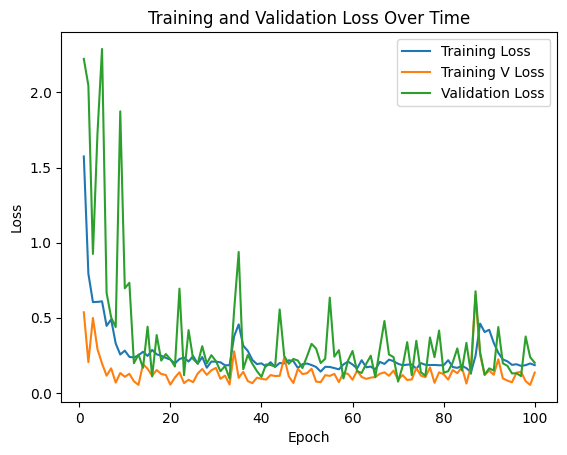

In [40]:
# Plot the training and validation loss
plt.plot(range(1, n_epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, n_epochs + 1), train_v_loss_list, label='Training V Loss')
plt.plot(range(1, n_epochs + 1), validation_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

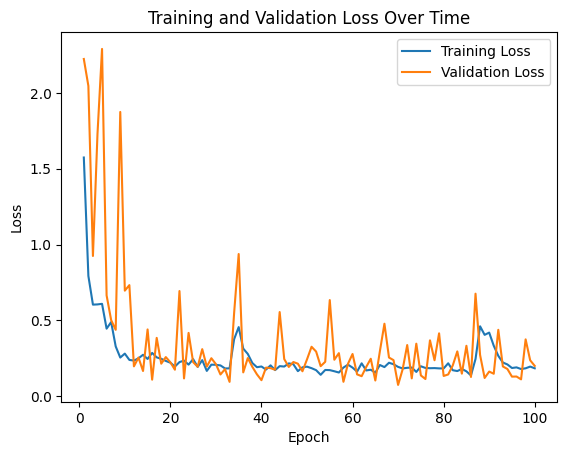

In [41]:
# Plot the training and validation loss
plt.plot(range(1, n_epochs + 1), train_loss_list, label='Training Loss')
#plt.plot(range(1, n_epochs + 1), train_v_loss_list, label='Training V Loss')
plt.plot(range(1, n_epochs + 1), validation_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [45]:
# save the model parameters (state_dict)
torch.save(model.state_dict(), '/content/reward_function_mode_state_dict_6.pth')

In [46]:
test_dataloader = DataLoader(TensorDataset(inp_test.float(), target_test.float()), batch_size=30, shuffle=True, drop_last=True)

In [47]:
import torch.nn.functional as F

In [49]:
def compute_loss(model, dataloader, loss_fn):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            predictions = model(inputs,targets)  # Forward pass
            loss = loss_fn(predictions, targets)  # Compute loss
            total_loss += loss.item() * len(inputs)
            num_samples += len(inputs)

    return total_loss / num_samples

# Define your loss function (e.g., Mean Squared Error for regression)
loss_fn = loss_function

# Calculate loss on the test dataset
test_loss = compute_loss(model, test_dataloader, loss_fn)
print(f'Loss on test dataset: {test_loss:.4f}')

Loss on test dataset: 0.1997
